<a href="https://colab.research.google.com/github/aarandjel/importance-sampling-with-feedforward-networks/blob/main/knock_out_barrier_call_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling for option pricing with feedforward networks
## A. Arandjelović

Let $r \in \mathbb{R}$ and $\sigma > 0$ be given constants.
We consider a filtered probability space $(\Omega, \mathcal{F}, \mathbb{F}, \mathbb{P})$ and an $(\mathbb{F}, \mathbb{P})$-standard Brownian motion $B = (B_{t})_{0 \le t \le T}$ for a finite time horizon $T > 0$.
The asset price $S$ is assumed to follow the dynamics

$$
\mathrm{d}S_{t} = r S_{t}\, \mathrm{d}t + \sigma S_{t}\, \mathrm{d}B_{t}, \quad S_{0} \in \mathbb{R},
$$

hence $S_{t} = S_{0}\exp{\bigl((r-\sigma^{2}/2)t + \sigma B_{t}\bigr)}$.

As a payoff we consider for a given strike $K > 0$ a call option with knock-out region $(L, U)^{\mathrm{c}}$:

$$
G(S) = \Bigl( S_{T} - K \Bigr)^{+} = \Bigl( S_{0}\mathrm{e}^{(r-\sigma^{2}/2)T + \sigma B_{T}} - K \Bigr)^{+}.
$$

In [ ]:
import sys
import time
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Minimum, Maximum
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version:  2.0.0
Keras version:  2.2.4-tf


In [ ]:
T = 1
N = 32
delta_t = T/N

S0 = 50
r = 0.05
sigma = 0.25

strike = 90

L = 20.0
U = 120.0

c = r - 0.5 * sigma ** 2

disc = np.exp(-T*r)

R = 5*10**5

d = 3               # number of layers in strategy (hidden and output)
n = 3               # nodes in the hidden layers
a = 0.0             # initial random weights mean
b = 1.0             # initial random weights sd
learnrate = 0.01    # learning rate in SGD

In [ ]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [ ]:
layers = []
for i in range(d):
    if i < d-1: 
        nodes = n
        layer = Dense(units=nodes, activation='tanh', trainable=True, name=str(i),
                     kernel_initializer=initializers.RandomNormal(a, b),
                     bias_initializer=initializers.RandomNormal(a, b))
    else:
        nodes = 1
        layer = Dense(units=nodes, activation='linear', trainable=True, name=str(i),
                     kernel_initializer=initializers.RandomNormal(a, b),
                     bias_initializer=initializers.RandomNormal(a, b))
    layers = layers + [layer]

In [ ]:
Ktrain = R
xtrain = ([0*np.ones((Ktrain,1))] + # t_0
          [0*np.ones((Ktrain,1))] + # B_0
          [S0*np.ones((Ktrain,1))] + # S_0
          [delta_t*np.ones((Ktrain,1))] + # time increment
          [0*np.ones((Ktrain,1))] + # initial value of the first part of the stoch exp
          [0*np.ones((Ktrain,1))] + # initial value of the second part of the stoch exp
          [np.random.normal(0,np.sqrt(delta_t),(Ktrain,1)) for i in range(N)]) # Brownian increments
ytrain = np.zeros((Ktrain, 1))

In [ ]:
t_0 = Input(shape=(1, ))
B_0 = Input(shape=(1, ))
S_0 = Input(shape=(1, ))
d_t = Input(shape=(1, ))
c_0 = Input(shape=(1, ))
c_1 = Input(shape=(1, ))

inputs = [t_0]+[B_0]+[S_0]+[d_t]+[c_0]+[c_1]

t_current = t_0
B_current = B_0
S_current = S_0

S_min = S_0
S_max = S_0

for j in range(N):
    
    strategy = t_current
    for k in range(d):
        strategy = layers[k](strategy)
    
    t_current = Add()([t_current, d_t])
    
    incr_B = Input(shape=(1, ))
    inputs = inputs + [incr_B]
    
    B_current = Add()([B_current, incr_B])
    
    helper_1 = Lambda(lambda x: K.exp(c*x))(t_current)
    helper_2 = Lambda(lambda x: S0 * K.exp(sigma * x))(B_current)
    S_current = Multiply()([helper_1, helper_2])
    
    S_min = Minimum()([S_min, S_current])
    S_max = Maximum()([S_max, S_current])
    
    helper_3 = Multiply()([strategy, incr_B])
    c_0 = Add()([c_0, helper_3])
    
    helper_4 = Multiply()([strategy, strategy])
    helper_5 = Multiply()([helper_4, d_t])
    c_1 = Add()([c_1, helper_5])
    
payoff = Lambda(lambda x: disc*K.relu(x - strike))(S_current)

# helper_6 = tf.cond(tf.logical_and(tf.less(L, S_min), tf.less(S_max, U)), 
#                    lambda: tf.constant([1.0]), 
#                    lambda: tf.constant([0.0]))
# payoff = Multiply()([helper_6, payoff])

helper_10 = Lambda(lambda x: K.exp(-0.5*x))(c_0)
helper_11 = Lambda(lambda x: K.exp(0.25*x))(c_1)
helper_12 = Multiply()([helper_10, helper_11])

payoff = Multiply()([payoff, helper_12])

outputs = Concatenate()([payoff, S_min, S_max])

In [ ]:
def custom_loss(y_true, y_pred):
    mask1 = K.less_equal(L, y_pred[:, 1])
    mask2 = K.less_equal(y_pred[:, 2], U)
    return K.sqrt(K.mean(K.square(y_pred[:, 0] * tf.cast(mask1, tf.float32) * tf.cast(mask2, tf.float32))))
    # return K.sqrt(K.mean(K.square(y_pred[:, 0])))

In [ ]:
adam = optimizers.Adam(learning_rate=learnrate, clipnorm=1)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam, loss=custom_loss)
# model.summary()

In [ ]:
model.fit(x=xtrain, y=ytrain, verbose=1, epochs=10, batch_size=1024)

Train on 500000 samples
Epoch 1/10
500000/500000 [==============================] - 11s 22us/sample - loss: 0.1603
Epoch 2/10
500000/500000 [==============================] - 6s 11us/sample - loss: 0.1229
Epoch 3/10
500000/500000 [==============================] - 6s 12us/sample - loss: 0.1232
Epoch 4/10
500000/500000 [==============================] - 6s 12us/sample - loss: 0.1228
Epoch 5/10
500000/500000 [==============================] - 6s 11us/sample - loss: 0.1230
Epoch 6/10
500000/500000 [==============================] - 6s 12us/sample - loss: 0.1229
Epoch 7/10
500000/500000 [==============================] - 6s 13us/sample - loss: 0.1233
Epoch 8/10
500000/500000 [==============================] - 6s 12us/sample - loss: 0.1232
Epoch 9/10
500000/500000 [==============================] - 6s 12us/sample - loss: 0.1227
Epoch 10/10
500000/500000 [==============================] - 6s 11us/sample - loss: 0.1234


In [ ]:
# model.save("04_arithmetic_asian")
# model = load_model("04_arithmetic_asian", custom_objects={"custom_loss": custom_loss, "a_const": a_const, "b_const": b_const, "delta_t": delta_t})
# model.summary()

In [ ]:
model_test = keras.Sequential()
model_test.add(Dense(n, activation="tanh", name="layer1", input_shape=(1, )))
model_test.add(Dense(n, activation="tanh", name="layer2"))
model_test.add(Dense(1, activation="linear", name="layer3"))

In [ ]:
model_test.build()

In [ ]:
model_test.layers[0].set_weights(model.layers[3].get_weights())
model_test.layers[1].set_weights(model.layers[5].get_weights())
model_test.layers[2].set_weights(model.layers[7].get_weights())

In [ ]:
N = 8
delta_t = T/N

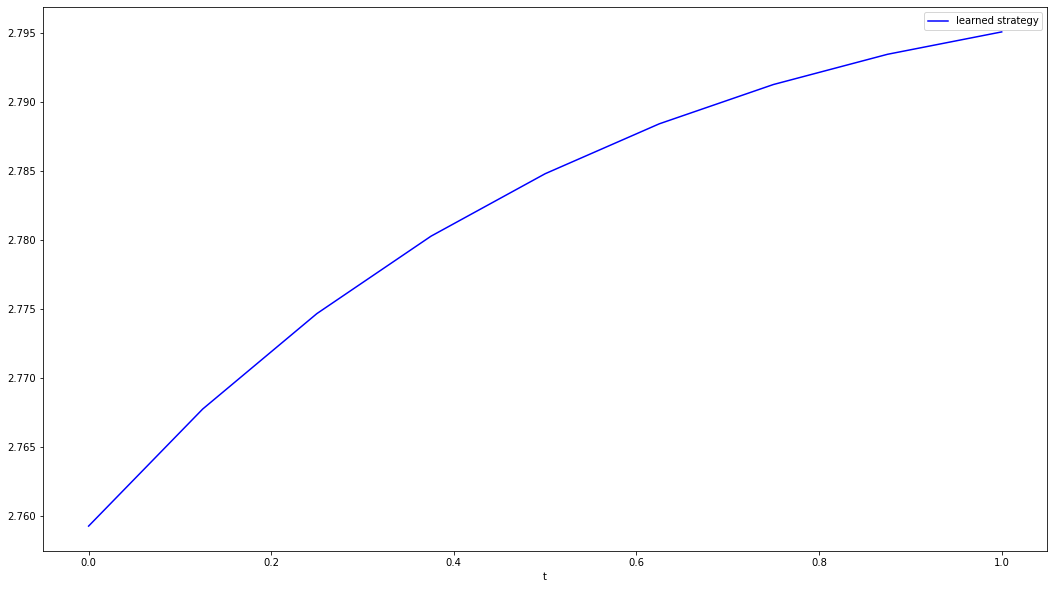

In [ ]:
t = np.linspace(0, T, N+1) 
learnedstrat = model_test.predict(t)

plt.figure(figsize=(18, 10)) 
plt.plot(t, learnedstrat, 'b', label='learned strategy') 
plt.xlabel("t")
plt.legend(loc="upper right")
plt.show()

In [ ]:
def payoff(x):
    x = np.cumsum(x)
    
    cond = 1
    for i in range(N+1):
        S_cur = S0*np.exp(c*delta_t*i + sigma * x[i])
        if S_cur <= L or S_cur >= U:
            cond = 0
    
    val = S0*np.exp(c*T + sigma*x[N])
    val = disc*np.clip(val - strike, 0, None) * cond
    return(val)

def payoff_revised(x, y):
    x = np.cumsum(x+y*delta_t)
    
    cond = 1
    for i in range(N+1):
        S_cur = S0*np.exp(c*delta_t*i + sigma * x[i])
        if S_cur <= L or S_cur >= U:
            cond = 0
    
    val = S0 * np.exp(c*T + sigma*x[N])
    val = disc*np.clip(val - strike, 0, None) * cond
    
    z = np.diff(x)
    
    abc_1 = np.sum(np.multiply(y[1:(N+1)], z)) 
    abc_2 = np.sum(np.multiply(y[1:(N+1)], y[1:(N+1)]) * delta_t)
    abc_3 = np.exp(-abc_1 + 0.5*abc_2)
    
    return(val*abc_3)

In [ ]:
N_sample = 50000

start_time = time.time() 

drift = np.concatenate((np.array([0]),learnedstrat[0:N].reshape((N))))

outcomes_standard = []
outcomes_is = []

for k in progressbar(range(N_sample), "Computing: ", 60):
    X = np.concatenate((np.array([0]),np.random.normal(0,np.sqrt(delta_t),N)))
    val_standard = payoff(X)
    val_is = payoff_revised(X, drift)
    
    outcomes_standard = outcomes_standard + [val_standard]
    outcomes_is = outcomes_is + [val_is]
    
mean_standard = np.mean(outcomes_standard)
sd_standard = np.std(outcomes_standard) / np.sqrt(N_sample)
mean_is = np.mean(outcomes_is)
sd_is = np.std(outcomes_is) / np.sqrt(N_sample)
    
elapsed_time = time.time() - start_time 

print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print("estimated price MS: ", np.around(mean_standard, 6))
print("estimated price IS: ", np.around(mean_is, 6))
print("standard error MS: ", np.around(sd_standard, 4), " (", np.around(sd_standard / mean_standard * 100, 2), "%)")
print("standard error IS: ", np.around(sd_is, 4), " (", np.around(sd_is / mean_is * 100, 2), "%)")
print("variance ratio: ", np.around(np.var(outcomes_standard) / np.var(outcomes_is), 2))

Computing: [############################################################] 50000/50000
elapsed time:  00:01:21
estimated price MS:  0.078545
estimated price IS:  0.079545
standard error MS:  0.0044  ( 5.64 %)
standard error IS:  0.0004  ( 0.56 %)
variance ratio:  100.65
